In [2]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.9 kB 2.6 MB/s eta 0:00:01
   ------------------------------- -------- 235.5/294.9 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\eleut\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


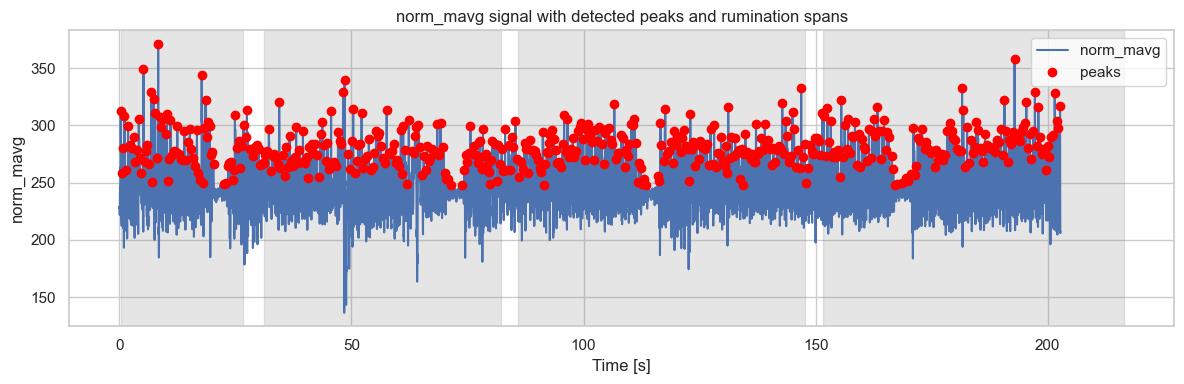

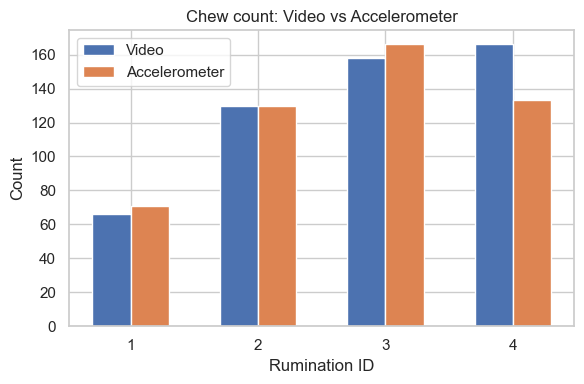

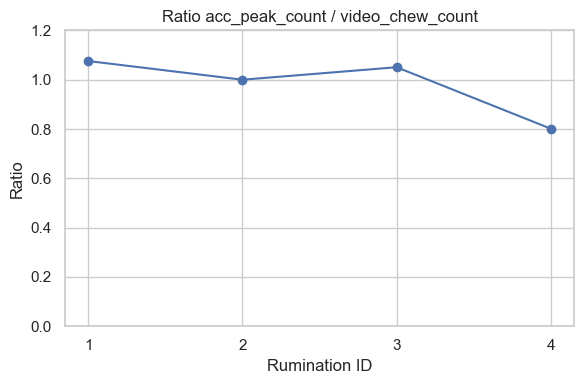

<Figure size 1200x400 with 0 Axes>

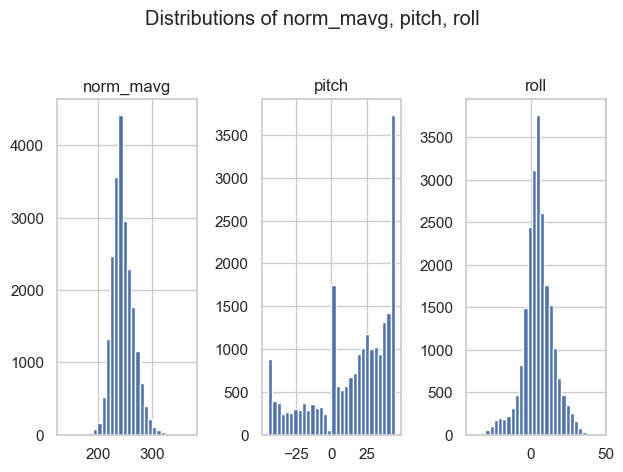

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

sns.set(style="whitegrid")

# 1) Load data and synchronize timestamps
chew_df = pd.read_csv(r"C:\Users\eleut\OneDrive\Desktop\csvvideo2.csv")          # video chew events
acc_df  = pd.read_csv(r"C:\Users\eleut\OneDrive\Desktop\Cow during rumination\video2\segment_01.csv")         # accelerometer data
chew_df['time_s'] = chew_df['Image index'] / 30.0  # convert frame index to seconds (30 fps)
acc_df['time_s']  = acc_df['time_ms']   / 1000.0   # convert milliseconds to seconds

# 2) Identify rumination segments in the video
chew_df = chew_df.sort_values('time_s').reset_index(drop=True)
chew_df['dt'] = chew_df['time_s'].diff().fillna(0)   # time difference between consecutive chews
# whenever dt > 2 s, start a new rumination segment
chew_df['rum_id'] = (chew_df['dt'] > 2.0).cumsum() + 1

# build 'bounds' dataframe with start/end times of each rumination
bounds = chew_df.groupby('rum_id').agg(
    start=('time_s','min'),
    end  =('time_s','max')
).reset_index()

# 3) Detect peaks in the accelerometer signal using optimal parameters
mean_nm   = acc_df['norm_mavg'].mean()             # mean of filtered norm signal
std_nm    = acc_df['norm_mavg'].std()              # std deviation of filtered norm signal
height_thr = mean_nm + 0.1 * std_nm                # threshold = mean + 0.1*std

# compute sampling frequency from median dt
median_dt  = acc_df['time_s'].diff().median()
fs         = 1.0 / median_dt
min_dist   = int(0.2 * fs)                         # minimum distance between peaks = 0.2 s

# find peaks in the norm_mavg signal
peaks_idx, _ = find_peaks(
    acc_df['norm_mavg'],
    height=height_thr,
    distance=min_dist
)
peak_times = acc_df.loc[peaks_idx, 'time_s'].values

# 4) Compare video-chew counts vs accelerometer-peaks per segment
records = []
for _, r in bounds.iterrows():
    n_vid = (chew_df['rum_id'] == r.rum_id).sum()
    n_acc = ((acc_df['time_s'] >= r.start) &
             (acc_df['time_s'] <= r.end) &
              acc_df.index.isin(peaks_idx)).sum()
    records.append({
        'rum_id':           r.rum_id,
        'video_chew_count': n_vid,
        'acc_peak_count':   n_acc,
    })
compare_df = pd.DataFrame(records)
compare_df['ratio'] = compare_df['acc_peak_count'] / compare_df['video_chew_count']

# norm_mavg with detected peaks and video segments
plt.figure(figsize=(12,4))
plt.plot(acc_df['time_s'], acc_df['norm_mavg'], label='norm_mavg')
plt.plot(peak_times,
         acc_df.loc[peaks_idx,'norm_mavg'],
         'o', color='red', label='peaks')
for _, row in bounds.iterrows():
    plt.axvspan(row.start, row.end, alpha=0.2, color='gray')
plt.title("norm_mavg signal with detected peaks and rumination spans")
plt.xlabel("Time [s]")
plt.ylabel("norm_mavg")
plt.legend()
plt.tight_layout()
plt.show()

# video vs accelerometer chew counts per segment
plt.figure(figsize=(6,4))
x = compare_df['rum_id']
plt.bar(x - 0.15, compare_df['video_chew_count'], width=0.3, label='Video')
plt.bar(x + 0.15, compare_df['acc_peak_count'], width=0.3, label='Accelerometer')
plt.title("Chew count: Video vs Accelerometer")
plt.xlabel("Rumination ID")
plt.ylabel("Count")
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()

# ratio between accelerometer and video counts
plt.figure(figsize=(6,4))
plt.plot(compare_df['rum_id'], compare_df['ratio'], 'o-')
plt.title("Ratio acc_peak_count / video_chew_count")
plt.xlabel("Rumination ID")
plt.ylabel("Ratio")
plt.ylim(0,1.2)
plt.xticks(compare_df['rum_id'])
plt.tight_layout()
plt.show()

# histograms of accelerometer features
plt.figure(figsize=(12,4))
acc_df[['norm_mavg','pitch','roll']].hist(bins=30, layout=(1,3))
plt.suptitle("Distributions of norm_mavg, pitch, roll")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [9]:
total_video = compare_df['video_chew_count'].sum()
total_acc   = compare_df['acc_peak_count'].sum()
overall_ratio = total_acc / total_video

ratio_stats = compare_df['ratio'].agg(['mean','median','min','max','std'])
corr = compare_df[['video_chew_count','acc_peak_count']].corr().iloc[0,1]
print(compare_df.to_string(index=False))
print(f"\nTotal video chews: {total_video}")
print(f"Total accelerometer chews: {total_acc}")
print(f"Overall ratio (Acc/Video): {overall_ratio:.3f}\n")

print("Ratio statistics per segment:")
print(ratio_stats.to_frame(name='Value'), "\n")

print(f"Pearson correlation between video and accelerometer counts: {corr:.3f}")

 rum_id  video_chew_count  acc_peak_count    ratio
    1.0                66              71 1.075758
    2.0               130             130 1.000000
    3.0               158             166 1.050633
    4.0               166             133 0.801205

Total video chews: 520
Total accelerometer chews: 500
Overall ratio (Acc/Video): 0.962

Ratio statistics per segment:
           Value
mean    0.981899
median  1.025316
min     0.801205
max     1.075758
std     0.124515 

Pearson correlation between video and accelerometer counts: 0.909
